In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pdb

%matplotlib inline

/Users/hangil/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import board, config, environment

In [3]:
tf.reset_default_graph()

In [4]:
# Parameters
board_size = 3
board_array_size = (board_size -1) * board_size * 2
env = environment.Environment(board_size)

In [5]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1, board_array_size],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([board_array_size,board_array_size],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,board_array_size],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [6]:
def filter_possible_moves(s, allQ):
    #min_num = np.min(allQ) -1
    #filteredQ = (s == 0) * (allQ - min_num) + min_num
    #if np.isnan(filteredQ).any():
    #    pdb.set_trace()
    filteredQ = allQ
    return np.argmax(filteredQ, 1), np.max(filteredQ), filteredQ

In [7]:
init = tf.initialize_all_variables()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 1000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        if i % 100 == 0:
            print i
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            allQ = sess.run(Qout,feed_dict={inputs1:s})
            a, _, filteredQ = filter_possible_moves(s, allQ)
            #pdb.set_trace()
            if np.random.rand(1) < e:
                a[0] = env.action_space_sample()
            #Get new state and reward from environment
            s1,r,d = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:s1})
            #Obtain maxQ' and set our target value for chosen action.
            _, maxQ1, _ = filter_possible_moves(s1, Q1)
            targetQ = filteredQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:s,nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0
100
200
300
400
500
600
700
800
900


In [8]:
wins = np.array(rList) > 0

print "Percent of succesful episodes: " + str(np.sum(wins)/num_episodes) + "%"

Percent of succesful episodes: 0%


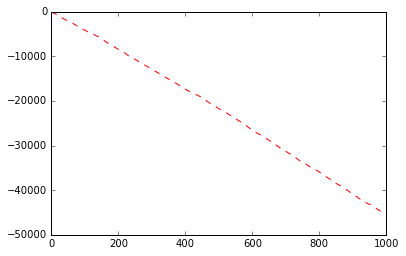

In [9]:
rList_cumsum = np.cumsum(rList)
plt.plot(rList_cumsum, '--r')

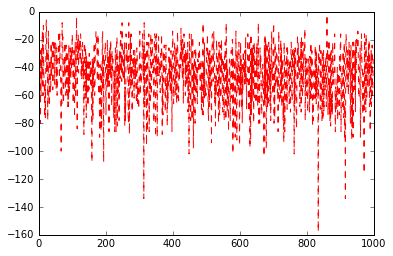

In [10]:
plt.plot(rList, '--r')